In [ ]:
import pandas as pd
import numpy as np
from io import StringIO
import os
os.chdir("../../..")
from Code.Training.get_performance import load_data


In [2]:
def generate_TPM(raw_mRNA, gene_lengths):
    '''
    1- Divide the read counts by the length of each gene in kilobases. This gives you reads per kilobase (RPK).
    2- Count up all the RPK values in a sample and divide this number by 1,000,000. This is your “per million” scaling factor.
    3- Divide the RPK values by the “per million” scaling factor. This gives you TPM.
    '''
    # Transform gene length in kb (RPK)
    gene_lengths["length"] = gene_lengths["length"] / 1000
    # Divide the raw counts
    raw_mRNA = raw_mRNA.join(gene_lengths)
    raw_mRNA = raw_mRNA.dropna()
    raw_mRNA = raw_mRNA.div(gene_lengths['length'], axis=0).drop("length", axis=1)
    # Get sample-wise counts
    count_sums = raw_mRNA.sum(0)
    # Divide number by 1_000_000
    count_sums = count_sums/1_000_000
    # Divide RPK values to obtain TPM
    raw_mRNA = raw_mRNA.div(count_sums, 1)
    return raw_mRNA

In [3]:
def generate_high_low(Y: pd.DataFrame) -> pd.DataFrame:
    """
    Classify rows based on row-wise mean into low/high categories.
    - Low (<25th percentile) -> 0
    - Middle (25-75th percentile) -> 3
    - High (>75th percentile) -> 1
    
    Returns a DataFrame with only low and high rows (middle removed).
    """
    row_mean = Y.mean(axis=1)

    low_thresh = row_mean.quantile(0.25)
    high_thresh = row_mean.quantile(0.75)

    classification = pd.Series(3, index=Y.index, name="class")  # middle = 3
    classification[row_mean < low_thresh] = 0
    classification[row_mean > high_thresh] = 1

    # Keep only low and high
    classification = classification[classification != 3]

    # Return as DataFrame (keeps 2D shape)
    return classification.to_frame()


In [ ]:
# Load RAW gene expression data
df = pd.read_csv("Data/mRNA/RAW/Ath_hormone/hormone_treatments_raw/raw_count_matrix.txt", sep='\t', index_col=0)
df = df.astype(float)
columns_old = df.columns
df = df.iloc[:, :-1]
df.columns = columns_old[1:]
## Load Gene lengths
gene_lengths = pd.read_table("Data/DNA/RAW/Ath/gene_lenghts.txt", header=None)
gene_lengths.columns = ["gene", "length"]
gene_lengths = gene_lengths.set_index("gene")
# Derive TCPM 
TPM = generate_TPM(raw_mRNA = df.copy(), gene_lengths=gene_lengths.copy())
#Y = Y[Y.std(axis=1) >= 1e-12]
Y = TPM
#Y = Y.iloc[:500, :]  # TMP
Y = generate_high_low(Y)



-----------------------------------------------------------------------------------------------------------------
Found: .fasta file: Data/DNA/RAW/Ath/TAIR10_chr_all.fas
Found: GFF file: Data/DNA/RAW/Ath/TAIR10_GFF3_genes.gff
Processing genome: TAIR10_chr_all
-----------------------------------------------------------------------------------------------------------------
Conversion completed. Output saved to Data/DNA/RAW/Ath/custom_promoter_coordinates_500up_199down_TSS.bed
Fasta file saved to Data/DNA/RAW/Ath/promoters_500up_199down_TSS.fasta, good to go!
Conversion completed. Output saved to Data/DNA/RAW/Ath/custom_promoter_coordinates_1up_2down_TTS.bed
Fasta file saved to Data/DNA/RAW/Ath/promoters_1up_2down_TTS.fasta, good to go!
Number of promoters with some non ACGT letters:  22
Number of promoters:  33602


Processing promoters: 100%|██████████| 33602/33602 [00:29<00:00, 1158.17it/s]


Number of unique k-mers: 2080


100%|██████████| 33602/33602 [00:04<00:00, 7502.96it/s]


Y shape (16308, 1)
C shape (33602, 2080)
Gene families file already available, adding non-included genes (if it applies)
No new genes to add.


In [ ]:
# Load genomic data
(
        mRNA_train,
        mRNA_validation,
        mRNA_test,
        TSS_sequences,
        TTS_sequences,
        metadata,
    ) = load_data(
        train_proportion=train_proportion,
        val_proportion=val_proportion,
        DNA_specs=dna_specs,
        treatments=linear_config["treatments"],
        problem_type=linear_config["problem_type"],
        mask_exons=linear_config["mask_exons"],
        dna_format=linear_config["dna_format"],
    )

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit

In [6]:
# Parameters
test_size = 0.2
random_state = 42

gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

# Split with grouping by gene families
train_index_rows, test_index_rows = next(gss.split(C, Y['class'], groups=gene_families))

X_train, X_test = C.iloc[train_index_rows], C.iloc[test_index_rows]
y_train, y_test = Y['class'].iloc[train_index_rows], Y['class'].iloc[test_index_rows]

# Optional: scale features for L1 regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define logistic regression with L1 penalty
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, verbose=1)

# Grid of C values to search (inverse of regularization strength)
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}

# 5-fold cross-validation for hyperparameter tuning
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', verbose = 2)
grid.fit(X_train_scaled, y_train)

# Best model
best_model = grid.best_estimator_
print("Best C:", grid.best_params_)

# Evaluate on test set
y_pred = best_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 7.354695
#nonzeros/#features = 2/2081
[CV] END ............................................C=0.001; total time=   0.6s
[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 7.353876
#nonzeros/#features = 2/2081
[CV] END ............................................C=0.001; total time=   0.7s
[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 2
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 7.353394
#nonzeros/#features = 2/2081
[CV] END ............................................C=0.001; total time=   0.7s
[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 7.353039
#non

Accuracy: 0.8068556361239289
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1567
           1       0.79      0.81      0.80      1467

    accuracy                           0.81      3034
   macro avg       0.81      0.81      0.81      3034
weighted avg       0.81      0.81      0.81      3034



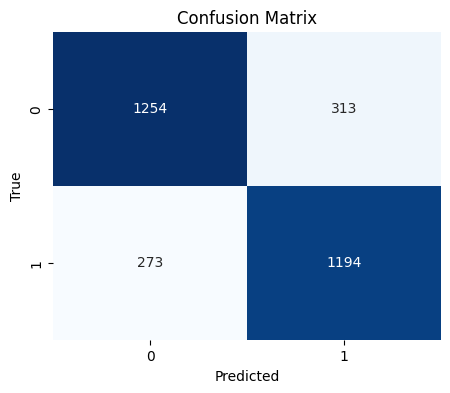

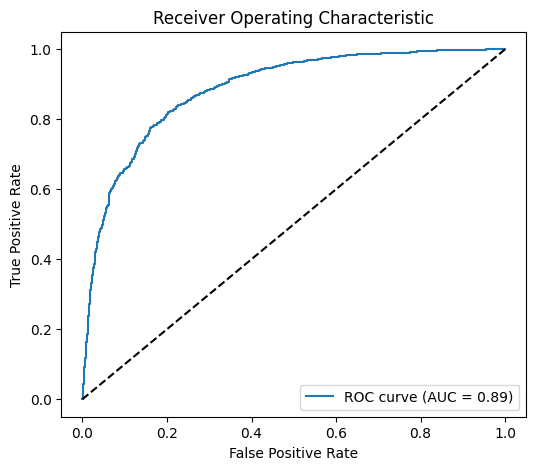

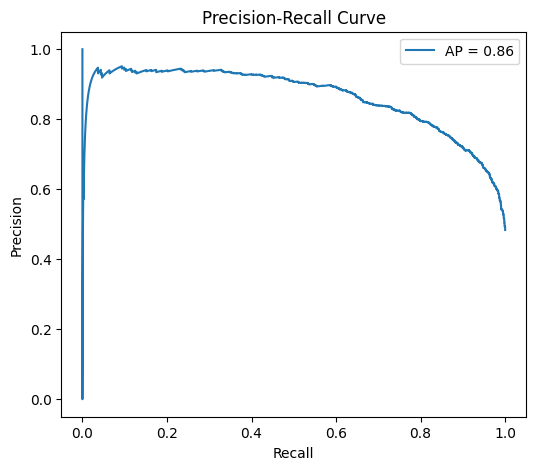

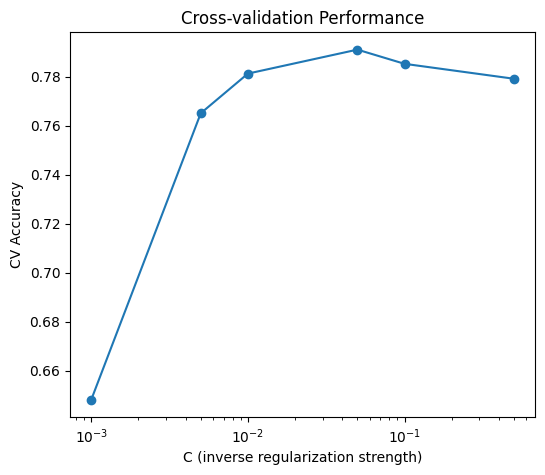

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, precision_recall_curve, 
    average_precision_score, ConfusionMatrixDisplay
)

# Predictions and probabilities
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]  # prob for class 1

# --- Accuracy & classification report (already in your code)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# --- Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- ROC curve & AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# --- Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {avg_prec:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# --- Cross-validation results from GridSearch
cv_results = grid.cv_results_

plt.figure(figsize=(6,5))
plt.plot(param_grid['C'], cv_results['mean_test_score'], marker='o')
plt.xscale("log")
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("CV Accuracy")
plt.title("Cross-validation Performance")
plt.show()

     feature  coefficient  abs_coef
1071  CATGCA    -0.201359  0.201359
45    AAAGTC     0.187670  0.187670
838   ATGGGC     0.175833  0.175833
836   ATGGCG     0.165588  0.165588
341   ACCGAC     0.157138  0.157138
...      ...          ...       ...
1946  TAAAGA    -0.000199  0.000199
1236  CCTCGA    -0.000196  0.000196
1696  GCATAC    -0.000044  0.000044
1769  GCTGAC    -0.000009  0.000009
12    AAAATA     0.000004  0.000004

[1162 rows x 3 columns]


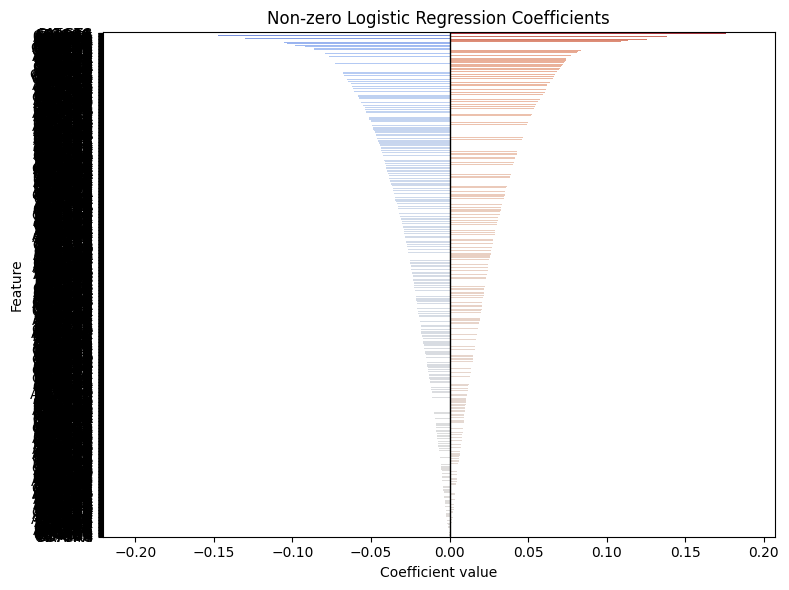

In [8]:

# Get coefficients and feature names
coef = best_model.coef_.ravel()  # shape (n_features,)
feature_names = X_train.columns

# Make DataFrame of coefficients
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef
})

# Filter out zeros
nonzero_coef = coef_df[coef_df["coefficient"] != 0].copy()

# Sort by absolute value
nonzero_coef["abs_coef"] = nonzero_coef["coefficient"].abs()
nonzero_coef = nonzero_coef.sort_values("abs_coef", ascending=False)

print(nonzero_coef)

# --- Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    data=nonzero_coef,
    x="coefficient", 
    y="feature",
    palette="coolwarm", 
    hue="coefficient",
    dodge=False,
    legend=False
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Non-zero Logistic Regression Coefficients")
plt.xlabel("Coefficient value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [27]:
nonzero_coef

,feature,coefficient,abs_coef
1071,CATGCA,-0.201456,0.201456
45,AAAGTC,0.187732,0.187732
838,ATGGGC,0.175913,0.175913
836,ATGGCG,0.165833,0.165833
341,ACCGAC,0.157034,0.157034
...,...,...,...
1374,CGGTGC,0.000281,0.000281
1696,GCATAC,-0.000152,0.000152
1236,CCTCGA,-0.000149,0.000149
1774,GCTTAA,0.000063,0.000063
